# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between EastEnders Characters

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the EastEnders script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximally distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those character document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **300 lines** of each character in the training data `training.csv` to create the training documents and a maximum of the first **50 lines** in the validation and test data (from `val.csv` and `test.csv`). This makes it more challenging, as the number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity-based information retrieval evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-6 below, which you need to complete as instructed.

**Refer to the material in units 8-9 for conceptual background.**

In [1]:
! pip install nltk


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
! pip install spacy


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
! pip install contractions


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
! python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 658.2 kB/s eta 0:00:0000:010:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
import string
import re
import spacy
from contractions import fix
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import math

import nltk

from sklearn.feature_extraction import DictVectorizer
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction import DictVectorizer


%matplotlib inline
pd.options.display.max_colwidth=500


[nltk_data] Downloading package punkt_tab to /Users/salva/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/salva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/salva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
val_path ='val.csv'
val_data = pd.read_csv(val_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
14008,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
14009,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
14010,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
14011,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


In [7]:
# Create one document per character
#for Q3 we will group lines by the episode and scene number and for each target line, we will create a scene text that includes
# _TARGET_SPEAKER_ around the target character's line and _OTHER_SPEAKER_ around all the other character's lines in the same scene and then we append the scene text to the target speaker's document
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them

    Improve this for Q3
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    grouped = df.groupby(['Episode','Scene'])

    for (episode,scene), df_group in grouped:
        for idx, row in df_group.iterrows():
            line = row.Line
            name = row.Character_name
            if (isinstance(line, float) and math.isnan(line)) or line == "":
                continue
            if not name in character_docs.keys():
                character_docs[name] = ""
                character_line_count[name] = 0
            if character_line_count[name]==max_line_count:
                continue
            
            scene_lines = []
            for idx2, row2 in df_group.iterrows():
                #mark the target line (same row)
                if idx2 == idx:
                    tagged_line = f"_TARGET_SPEAKER_ {row2['Line']} _END_TARGET_ "
                    character_line_count[name] += 1
                else:
                    tagged_line = f"_OTHER_SPEAKER_ {row2['Line']} _END_OTHER_ "
                    #character_line_count[name] += 1
                
                scene_lines.append(tagged_line)
                if character_line_count[name] >= max_line_count:
                    break
            scene_text = " ".join(scene_lines)

            #apending scene block to the target speaker's doc
            character_docs[name] += scene_text
            
                

    return character_docs

Since adding lines from different characters ended up reducing the accuracy and increasing the mean rank, one of the possibilities is that the 300 lines limit made the 300 lines be more focused around other character's sentences instead of the target speaker. Another approach is two only add a window of other people's lines as scene context so the model would see enough samples of target speaker's language.

In [ ]:
import math

def create_character_document_from_dataframe_windowed(df, max_line_count, window=2):
    """
    Returns a dict with the name of the character as key,
    and a large string of their lines + context lines from the same scene
    within a window of +/- `window` lines, but WITHOUT using _EOL_ tokens.

    ::max_line_count:: the maximum number of 'windowed scene blocks'
                       to be added per character to avoid huge docs.
    ::window:: how many lines before and after the target line to include
               from the same scene.
    """
    character_docs = {}
    character_line_count = {}

    # Group the dataframe by (Episode, Scene)
    grouped = df.groupby(['Episode', 'Scene'])

    for (episode, scene), group_df in grouped:
        # sort lines by index
        group_df_sorted = group_df.sort_index()
        # list of the sorted indexes for window slicing
        sorted_indices = group_df_sorted.index.tolist()

        # for each line in a specific scene
        for idx in sorted_indices:
            row = group_df_sorted.loc[idx]
            line = row['Line']
            name = row['Character_name']
            if not isinstance(line, str) or line.strip() == "":
                continue
            if name not in character_docs:
                character_docs[name] = ""
                character_line_count[name] = 0

            if character_line_count[name] >= max_line_count:
                continue
            #current row's position
            row_position = sorted_indices.index(idx)

            # compute start/end for the window
            start_pos = max(0, row_position - window)
            end_pos   = min(len(sorted_indices) - 1, row_position + window)

            # extract just this window of lines from the scene
            window_indices = sorted_indices[start_pos : end_pos + 1]
            window_rows = group_df_sorted.loc[window_indices]

            # build text for this window
            scene_lines = []
            for i2 in window_rows.index:
                row2 = window_rows.loc[i2]
                # if it's the target line, tag it as _TARGET_SPEAKER_ ... _END_TARGET_
                if i2 == idx:
                    tagged_line = f"_TARGET_SPEAKER_ {row2['Line']} _END_TARGET_"

                # if it's other people's lines, tag it as _OTHER_SPEAKER_ ... _END_OTHER_
                else:
                    tagged_line = f"_OTHER_SPEAKER_ {row2['Line']} _END_OTHER_"
                scene_lines.append(tagged_line)

            # Join lines with a space
            scene_text = " ".join(scene_lines)

            # append windowed text block to the target speaker's doc with a space
            character_docs[name] += scene_text + " "
            character_line_count[name] += 1

    print("lines per character:", character_line_count)
    return character_docs


In [9]:
# print out the number of words each character has in the training set
# only use the first 300 lines of each character
train_character_docs = create_character_document_from_dataframe_windowed(train_data, max_line_count=300,window =2)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character: {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'ROXY': 300, 'TANYA': 300, 'SEAN': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
Num. Characters:  16 

SHIRLEY Number of Words:  15485
OTHER Number of Words:  12667
JACK Number of Words:  15704
RONNIE Number of Words:  15767
ROXY Number of Words:  15467
TANYA Number of Words:  15354
SEAN Number of Words:  13969
MAX Number of Words:  16906
IAN Number of Words:  15689
JANE Number of Words:  15449
STACEY Number of Words:  15233
PHIL Number of Words:  17011
HEATHER Number of Words:  15774
MINTY Number of Words:  16486
CHRISTIAN Number of Words:  15994
CLARE Number of Words:  16548
total words 249503


In [10]:
train_character_docs["SHIRLEY"]

'_TARGET_SPEAKER_ Look at ya, not a mark on ya. And you think you\'re an unlucky man. _END_TARGET_ _OTHER_SPEAKER_ Shirl... _END_OTHER_ _OTHER_SPEAKER_ Where you going? _END_OTHER_ _TARGET_SPEAKER_ I\'m gonna get help. Oh where\'s my phone? Oh Kevin. Kevin you smashed it, didn\'t ya? Kevin, Kevin, where\'s your phone? _END_TARGET_ _OTHER_SPEAKER_ In my right pocket. _END_OTHER_ _OTHER_SPEAKER_ I\'m done for. _END_OTHER_ _OTHER_SPEAKER_ In my right pocket. _END_OTHER_ _OTHER_SPEAKER_ I\'m done for. _END_OTHER_ _TARGET_SPEAKER_ No you\'re not, ssh, shut up. _END_TARGET_ _OTHER_SPEAKER_ I\'m done for. _END_OTHER_ _OTHER_SPEAKER_ Fire brigade and ambulance. There\'s been an accident. On an industrial estate in Walford. ...Um, the Marsh Lane industrial estate. Please come quick. My husband- he\'s not my husband- my friend. He\'s trapped in the car. Please come quick... Shirley Carter. 82 82B George Street, Walford, E20. Please hurry, please come quick. _END_OTHER_ _OTHER_SPEAKER_ No you\'re

In [11]:

def pre_process(text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
     """
    # 1- converting text to lowercase
    text = text.lower()
    #text = text.replace('_eol_','_EOL_')
    # 2- remove punctuation (.,!?-) at the beginning and end of wordsby replacing them with a space
    
    text = re.sub(r'\b[.,!?-]+|[.,!?-]+\b', '', text)
    
    # 3- expand contractions
    text = fix(text)

    # 4- remove repeated characters
    text = re.sub(r'(.)\1+', r'\1\1', text)

    # 5- using nltk's word tokenizer instead of splitting by whitespaces
    tokens = word_tokenize(text)   # just a simple tokenization, to be replaced
    # 6- remove tokens with digits
    tokens = [token for token in tokens if not any(char.isdigit() for char in token)]
   
    # 7- remove filler words
    filler_words = {'um', 'uh', 'hmm', 'ah', 'er', 'haha', 'hehe', 'huh'}
    scene_tags = ["_target_speaker_","_end_target_","_other_speaker_","_end_other_"]
    tokens = [word for word in tokens if word.lower() not in filler_words or word == '_EOL_' or word in scene_tags]
    
    # 8- removing stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    return tokens



In [12]:
train_character_docs["SHIRLEY"]

'_TARGET_SPEAKER_ Look at ya, not a mark on ya. And you think you\'re an unlucky man. _END_TARGET_ _OTHER_SPEAKER_ Shirl... _END_OTHER_ _OTHER_SPEAKER_ Where you going? _END_OTHER_ _TARGET_SPEAKER_ I\'m gonna get help. Oh where\'s my phone? Oh Kevin. Kevin you smashed it, didn\'t ya? Kevin, Kevin, where\'s your phone? _END_TARGET_ _OTHER_SPEAKER_ In my right pocket. _END_OTHER_ _OTHER_SPEAKER_ I\'m done for. _END_OTHER_ _OTHER_SPEAKER_ In my right pocket. _END_OTHER_ _OTHER_SPEAKER_ I\'m done for. _END_OTHER_ _TARGET_SPEAKER_ No you\'re not, ssh, shut up. _END_TARGET_ _OTHER_SPEAKER_ I\'m done for. _END_OTHER_ _OTHER_SPEAKER_ Fire brigade and ambulance. There\'s been an accident. On an industrial estate in Walford. ...Um, the Marsh Lane industrial estate. Please come quick. My husband- he\'s not my husband- my friend. He\'s trapped in the car. Please come quick... Shirley Carter. 82 82B George Street, Walford, E20. Please hurry, please come quick. _END_OTHER_ _OTHER_SPEAKER_ No you\'re

In [13]:
pre_process(train_character_docs["SHIRLEY"])

['_target_speaker_',
 'look',
 'ya',
 'mark',
 'ya',
 'think',
 'unlucky',
 'man',
 '_end_target_',
 '_other_speaker_',
 'shirl',
 '_end_other_',
 '_other_speaker_',
 'going',
 '_end_other_',
 '_target_speaker_',
 'going',
 'get',
 'help',
 'oh',
 'phone',
 'oh',
 'kevin',
 'kevin',
 'smashed',
 'ya',
 'kevin',
 'kevin',
 'phone',
 '_end_target_',
 '_other_speaker_',
 'right',
 'pocket',
 '_end_other_',
 '_other_speaker_',
 'done',
 '_end_other_',
 '_other_speaker_',
 'right',
 'pocket',
 '_end_other_',
 '_other_speaker_',
 'done',
 '_end_other_',
 '_target_speaker_',
 'ssh',
 'shut',
 '_end_target_',
 '_other_speaker_',
 'done',
 '_end_other_',
 '_other_speaker_',
 'fire',
 'brigade',
 'ambulance',
 'accident',
 'industrial',
 'estate',
 'walford',
 'marsh',
 'lane',
 'industrial',
 'estate',
 'please',
 'come',
 'quick',
 'husband',
 'husband',
 'friend',
 'trapped',
 'car',
 'please',
 'come',
 'quick',
 'shirley',
 'carter',
 'george',
 'street',
 'walford',
 'please',
 'hurry',
 '

In [14]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

example: training chorpus for CHRISTIAN

In [15]:
training_corpus[0]

('CHRISTIAN',
 ['_other_speaker_',
  'point',
  'tonight',
  'idea',
  '_end_other_',
  '_other_speaker_',
  'yeah',
  'point',
  'millionth',
  'time',
  'said',
  '_end_other_',
  '_target_speaker_',
  'lesley',
  'really',
  'glad',
  'must',
  'ian',
  '_end_target_',
  '_other_speaker_',
  'yeah',
  'hi',
  '_end_other_',
  '_other_speaker_',
  'partner',
  'ashley',
  '_end_other_',
  '_other_speaker_',
  'lesley',
  'really',
  'glad',
  'must',
  'ian',
  '_end_other_',
  '_other_speaker_',
  'yeah',
  'hi',
  '_end_other_',
  '_target_speaker_',
  'partner',
  'ashley',
  '_end_target_',
  '_other_speaker_',
  'oh',
  'pleased',
  'meet',
  '_end_other_',
  '_other_speaker_',
  'hi',
  'asley',
  'nice',
  'meet',
  'table',
  'want',
  'sit',
  '_end_other_',
  '_other_speaker_',
  'oh',
  'pleased',
  'meet',
  '_end_other_',
  '_other_speaker_',
  'hi',
  'asley',
  'nice',
  'meet',
  'table',
  'want',
  'sit',
  '_end_other_',
  '_target_speaker_',
  'lovely',
  'little'

In [16]:
nlp = spacy.load("en_core_web_sm")
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
from transformers import pipeline

def add_sentiment_scores(character_doc, counts):
    text = ' '.join(character_doc)
    sentiment = sia.polarity_scores(text)
    counts['sentiment_pos'] = sentiment['pos']
    counts['sentiment_neg'] = sentiment['neg']
    counts['sentiment_neu'] = sentiment['neu']
    return counts


# Load emotion classifier
emotion_classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", top_k=None)

def add_emotion_scores(character_doc, counts, chunk_size=500):
    """
    Adds emotion scores to the feature dictionary by analyzing chunks of text.
    Splits the text into smaller chunks if it exceeds the model's input size.
    
    ::character_doc:: List of tokens representing the character's dialogue.
    ::counts:: Dictionary of feature counts.
    ::chunk_size:: Maximum number of characters in each chunk.
    """
    text = ' '.join(character_doc)
    # Split the text into smaller chunks
    chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
    
    # Aggregate emotion scores
    emotion_scores = Counter()
    for chunk in chunks:
        # Classify emotions for each chunk
        emotions = emotion_classifier(chunk[:chunk_size])  # Truncate chunk to fit model limits
        emotions=emotions[0]

        for emotion in emotions:  # Iterate through predictions
            emotion_scores[emotion['label']] += emotion['score']  # Aggregate scores
    
    # Normalize by the number of chunks to get average scores
    for emotion, score in emotion_scores.items():
        counts[f"emotion_{emotion}"] = score / len(chunks)
    
    return counts




def to_feature_vector_dictionary(character_doc, extra_features,method):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    counts = Counter(character_doc)  # for now a simple count

    #1- add bigrams
    if "bigram" in method:
        bigrams = zip(character_doc, character_doc[1:])
        bigram_counts = Counter(['_'.join(bigram) for bigram in bigrams])
        counts.update(bigram_counts)
    
    #2- add trigrams
    if "trigram" in method:
        trigrams = zip(character_doc, character_doc[1:],character_doc[2:])
        trigram_counts = Counter(['_'.join(trigram) for trigram in trigrams])
        counts.update(trigram_counts)
    #3- add pos counts
    if "pos" in method:
        doc = nlp(' '.join(character_doc))
        pos_counts = Counter([token.pos_ for token in doc])
        counts.update({f"POS_{pos}": count for pos, count in pos_counts.items()})
    if "sentiment" in method:
        counts = add_sentiment_scores(character_doc,counts)
    if "emotion" in method:
        counts = add_emotion_scores(character_doc, counts)
    if "linguistic" in method:
        counts['avg_sentence_length'] = len(character_doc) / max(1, character_doc.count('_TARGET_SPEAKER_'))
        counts['type_token_ratio'] = len(set(character_doc)) / len(character_doc)

    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] += 1
    return dict(counts)  

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/salva/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/Users/salva/Desktop/qmul/lab_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0


In [17]:
training_corpus[0][1]

['_other_speaker_',
 'point',
 'tonight',
 'idea',
 '_end_other_',
 '_other_speaker_',
 'yeah',
 'point',
 'millionth',
 'time',
 'said',
 '_end_other_',
 '_target_speaker_',
 'lesley',
 'really',
 'glad',
 'must',
 'ian',
 '_end_target_',
 '_other_speaker_',
 'yeah',
 'hi',
 '_end_other_',
 '_other_speaker_',
 'partner',
 'ashley',
 '_end_other_',
 '_other_speaker_',
 'lesley',
 'really',
 'glad',
 'must',
 'ian',
 '_end_other_',
 '_other_speaker_',
 'yeah',
 'hi',
 '_end_other_',
 '_target_speaker_',
 'partner',
 'ashley',
 '_end_target_',
 '_other_speaker_',
 'oh',
 'pleased',
 'meet',
 '_end_other_',
 '_other_speaker_',
 'hi',
 'asley',
 'nice',
 'meet',
 'table',
 'want',
 'sit',
 '_end_other_',
 '_other_speaker_',
 'oh',
 'pleased',
 'meet',
 '_end_other_',
 '_other_speaker_',
 'hi',
 'asley',
 'nice',
 'meet',
 'table',
 'want',
 'sit',
 '_end_other_',
 '_target_speaker_',
 'lovely',
 'little',
 'place',
 '_end_target_',
 '_other_speaker_',
 'seen',
 'flesh',
 'ashley',
 'lesley

In [ ]:

#length of riginal corpus
print(len(training_corpus[0][1]))
#length of corpus with bigrams and trigrams added
print(len(to_feature_vector_dictionary(training_corpus[0][1], [],["bigram","trigram"])))

9067
10325


In [20]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
tfidf_transformer = TfidfTransformer()
feature_selector = SelectKBest(chi2, k=2000) 

def create_document_matrix_from_corpus(corpus, matrix_type, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q2.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    #converting to feature dictionaries
    feature_dict = [to_feature_vector_dictionary(doc,[],["bigram","sentiment","emotion","linguistic"]) for name,doc in corpus]
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit(feature_dict)
    doc_feature_matrix = corpusVectorizer.transform(feature_dict)

    #apply tf-idf transformation
    if "tfidf" in matrix_type:
        if fitting:
            tfidf_transformer.fit(doc_feature_matrix)
        doc_feature_matrix = tfidf_transformer.transform(doc_feature_matrix)

    #feature selection with k-best
    if "selection" in matrix_type:
        if fitting:
            feature_selector.fit(doc_feature_matrix, [name for name, doc in corpus])
        doc_feature_matrix = feature_selector.transform(doc_feature_matrix)

    
    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus,["tfidf","selection"],fitting=True)

In [21]:
training_feature_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3511 stored elements and shape (16, 2000)>

In [22]:
# get the validation data- only 50 lines used for each character
val_character_docs = create_character_document_from_dataframe_windowed(val_data, max_line_count=50,window=2)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character: {'OTHER': 50, 'HEATHER': 43, 'TANYA': 50, 'JACK': 50, 'RONNIE': 40, 'JANE': 50, 'STACEY': 50, 'SEAN': 50, 'PHIL': 32, 'SHIRLEY': 50, 'ROXY': 30, 'IAN': 50, 'MINTY': 50, 'CHRISTIAN': 30, 'CLARE': 28, 'MAX': 50}
Num. Characters:  16 

OTHER Num of Words:  2382
HEATHER Num of Words:  2284
TANYA Num of Words:  2506
JACK Num of Words:  2590
RONNIE Num of Words:  1983
JANE Num of Words:  2907
STACEY Num of Words:  2573
SEAN Num of Words:  2758
PHIL Num of Words:  1778
SHIRLEY Num of Words:  2794
ROXY Num of Words:  1391
IAN Num of Words:  3019
MINTY Num of Words:  2829
CHRISTIAN Num of Words:  1623
CLARE Num of Words:  1727
MAX Num of Words:  2687
total words 37831


In [23]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus,["tfidf","selection"], fitting=False)

In [24]:
val_feature_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 613 stored elements and shape (16, 2000)>

In [25]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [26]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [27]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [28]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.9375
mean cosine similarity 0.46005175535385523
14 correct out of 16 / accuracy: 0.875


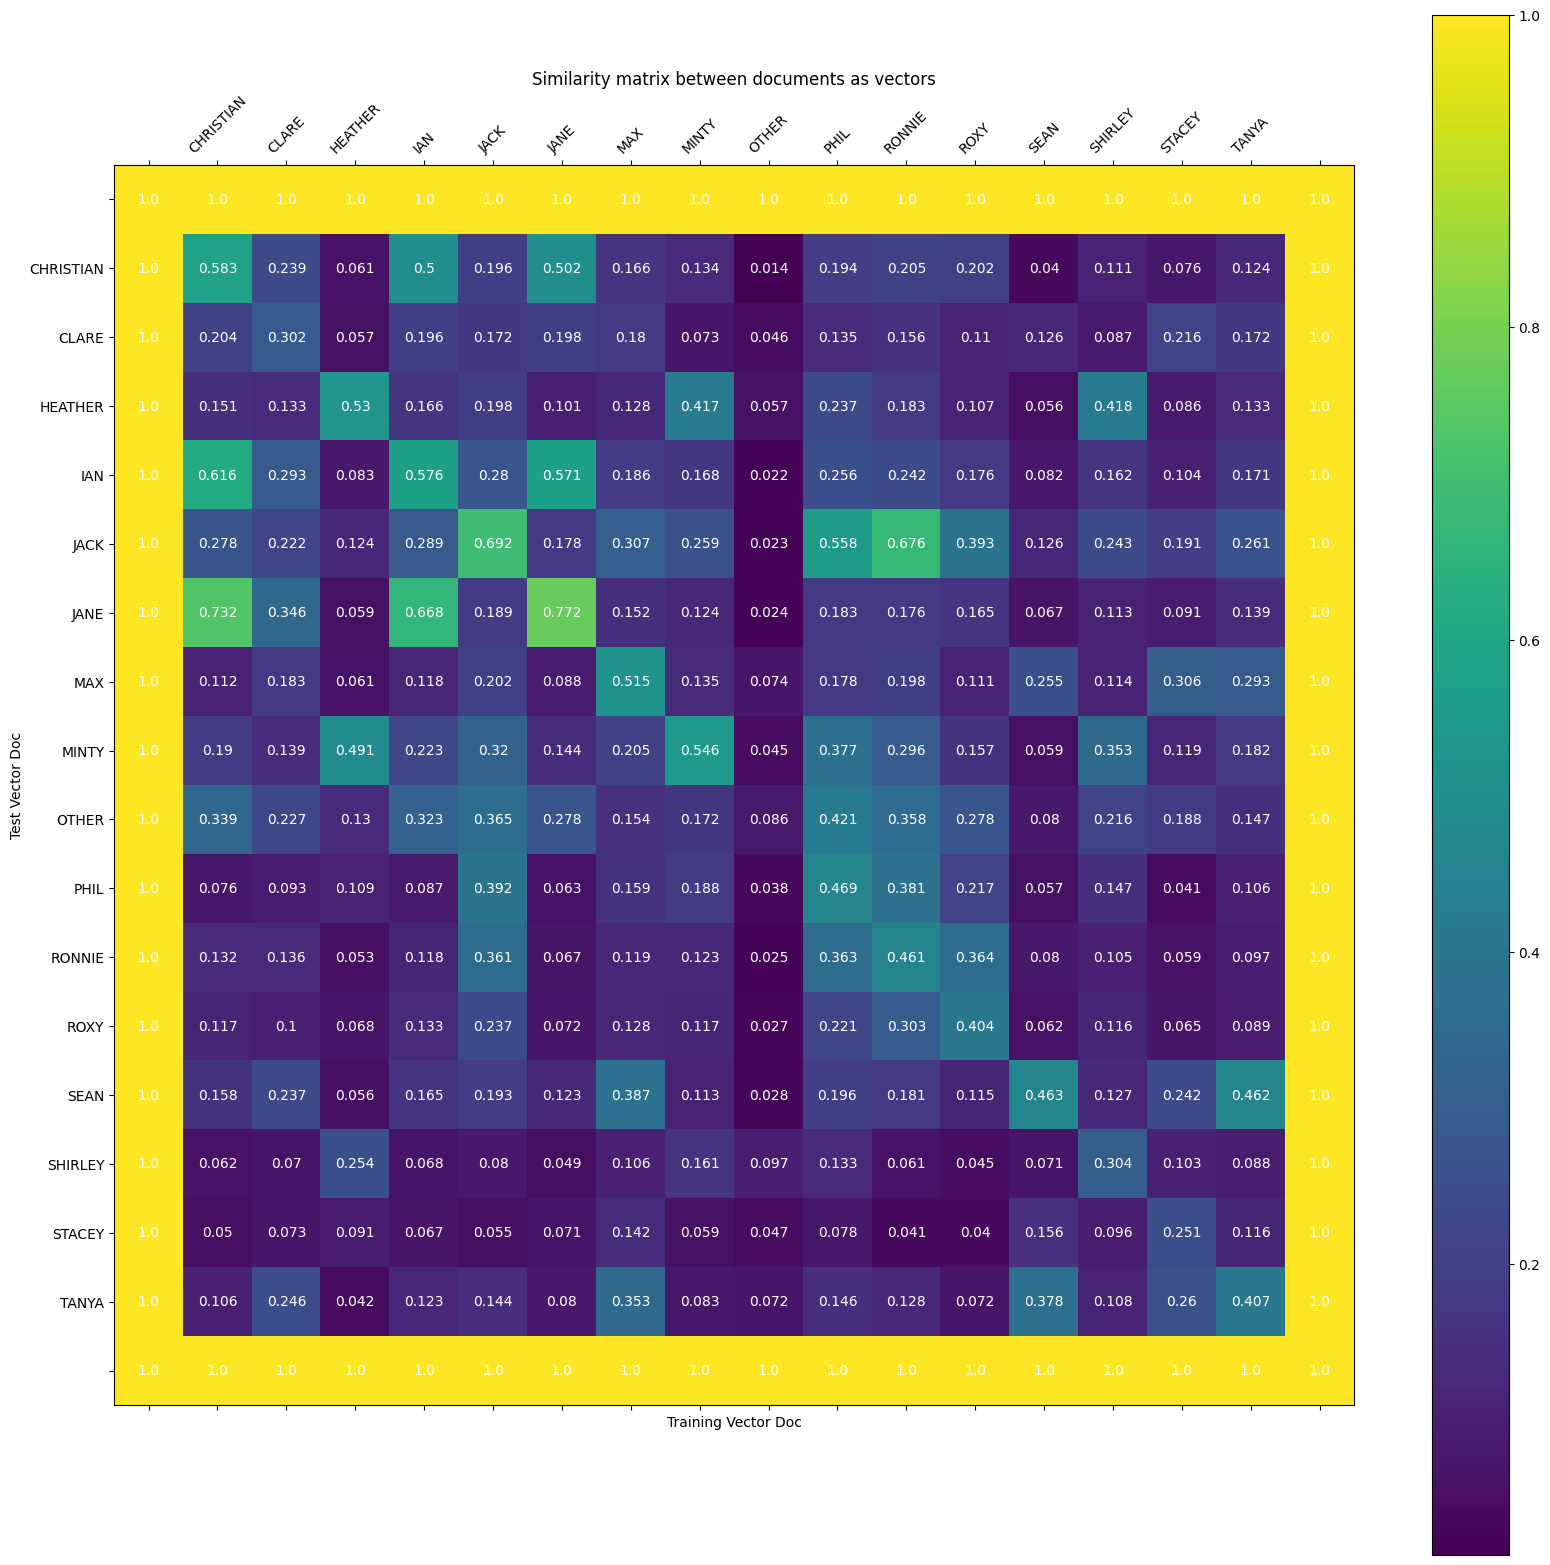

In [29]:
plot_heat_map_similarity(df)

# Q1. Improve pre-processing (20 marks)
Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the first 300 and 50 lines from the training and validation files, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **16**. Initially, the code in this template achieves a mean rank of **4.3**  and accuracy of **0.25** on the test set and a mean rank of **3.6** and accuracy of **0.31** on the validation set - you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.


# Q2. Improve linguistic feature extraction (30 marks)
Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` and `create_document_matrix_from_corpus` functions above. Examples of extra features could include extracting n-grams of different lengths and including POS tags. You could also use sentiment analysis or another text classifier's result when applied to the features for each character document. You could even use a gender classifier trained on the same data using the GENDER column **(but DO NOT USE the GENDER column directly in the features for the final vector)**.

Matrix transformation techniques like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) are commonly used to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizer (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

Other options include using feature selection/reduction with techniques like minimum/maximum document frequency and/or feature selection like k-best selection using different statistical tests https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html. 

Again, develop your system using the training and validation sets and note the effect/improvement in mean rank with the techniques you use.

# Q3. Add dialogue context and scene features (15 marks)
Adjust `create_character_document_from_dataframe` and the other functions appropriately so the data incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (before and after the target character's lines). HINT: you should use the *Episode* and *Scene* columns to check which characters are in the same scene to decide whether to include their lines or not. Only the lines from the same *Scene* can be added as the context as lines from different *Scene* are irrelevant.  **(but DO NOT USE the GENDER and CHARACTER columns directly)**.

# Q4. Parameter Search (15 marks)
It is a good practice to conduct a systematic parameter search instead of a random search as this will give you more 
reliable results. Given the scope of this assignment, it is possible to conduct a **grid search** on options you decided to try within the individual questions. The grid search should be done within the individual questions (i.e. Q1-Q3), and the later question should adopt the best settings from the previous questions. There is no need to do a grid search over all configurations from all questions as this will easily make the search unrealistic. E.g. Suppose we need 32, 90, and 4 runs to finish the grid search within questions, a cross-question grid search would need 32x90x4 = 11520 runs!                                                                      

# Q5. Analyse the similarity results (10 marks)
From your system so far run on the training/validation sets, identify the heldout character vectors ranked closest to each character's training vector which are not the character themselves, and those furthest away, as displayed using the `plot_heat_map_similarity` function. In your report, try to ascribe reasons why this is the case, particularly for those where there isn't a successful highest match between the target character in the training set and that character's vector in the heldout set yet. Observations you could make include how their language use is similar, resulting in similar word or ngram features.

# Q6. Run on final test data  (10 marks)
Test your best system using the code below to train on the training data (using the first 300 lines per character maximum) and do the final testing on the test file (using the first 50 lines per character maximum).

Make any necessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank and accuracy of document selection are on the test data.

In [30]:
# redo on training data with the first 300 character lines used
train_character_docs = create_character_document_from_dataframe_windowed(train_data, max_line_count=300,window = 2)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

training_feature_matrix = create_document_matrix_from_corpus(training_corpus,["tfidf","selection"], fitting=True)

# get the test data using 50 lines per character
test_character_docs = create_character_document_from_dataframe_windowed(test_data, max_line_count=50,window =2)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc)) for name, doc in sorted(test_character_docs.items())]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus,["tfidf","selection"], fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character: {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'ROXY': 300, 'TANYA': 300, 'SEAN': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}
Num. Characters:  16 

SHIRLEY Number of Words:  15485
OTHER Number of Words:  12667
JACK Number of Words:  15704
RONNIE Number of Words:  15767
ROXY Number of Words:  15467
TANYA Number of Words:  15354
SEAN Number of Words:  13969
MAX Number of Words:  16906
IAN Number of Words:  15689
JANE Number of Words:  15449
STACEY Number of Words:  15233
PHIL Number of Words:  17011
HEATHER Number of Words:  15774
MINTY Number of Words:  16486
CHRISTIAN Number of Words:  15994
CLARE Number of Words:  16548
total words 249503
lines per character: {'SHIRLEY': 50, 'OTHER': 50, 'HEATHER': 50, 'PHIL': 41, 'SEAN': 50, 'TANYA': 50, 'MAX': 50, 'JACK': 50, 'IAN': 50, 'JANE': 50, 'STACEY': 50, 'ROXY': 48, 'RONNIE': 50, 'CHRISTIAN': 50, 'MINTY': 48, 'CLARE': 45}